<a href="https://colab.research.google.com/github/ngcthanh2903/pytorch/blob/main/cifar10torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import cifar10

In [161]:
(x_train, y_train), (x_test, y_test) =cifar10.load_data()
print(x_test.dtype)

uint8


In [162]:
x_train=x_train.reshape(-1,3,32,32)
x_test=x_test.reshape(-1,3,32,32)


In [163]:
print(x_train.shape)
print(x_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [164]:
import torch
import torch.nn as nn
import torch.optim.adam as adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np


In [165]:
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
x_train = x_train.to(torch.float32)
x_test = x_test.to(torch.float32)

In [166]:
batch_size =64
train_ds = TensorDataset(x_train,y_train)
test_ds = TensorDataset(x_test,y_test)
train_dl = DataLoader(train_ds,batch_size,shuffle=True)
test_dl = DataLoader(test_ds,batch_size,shuffle=True)

In [167]:
y_train.shape


torch.Size([50000, 1])

In [168]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,padding=2)
        self.conv2 = nn.Conv2d(32,64,kernel_size= 3,padding=2)
        self.conv3 = nn.Conv2d(64,64,kernel_size=3,padding=2)
        self.conv3_drop = nn.Dropout2d()
        self.conv4 = nn.Conv2d(64,128,kernel_size=3,padding=2)
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 10)

        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        #print(x.shape)
        #print(x.reshape(x.shape[0],-1).shape)
        x = x.view(-1, 1152)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [169]:
from torchsummary import summary
model = Net()
summary(model, (3, 32, 32))
loss_fn = CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             896
            Conv2d-2           [-1, 64, 19, 19]          18,496
            Conv2d-3           [-1, 64, 11, 11]          36,928
         Dropout2d-4           [-1, 64, 11, 11]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
            Linear-6                  [-1, 100]         115,300
            Linear-7                   [-1, 10]           1,010
Total params: 246,486
Trainable params: 246,486
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.63
Params size (MB): 0.94
Estimated Total Size (MB): 1.58
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [170]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [171]:
n_epochs = 3
log_interval = 10
torch.backends.cudnn.enabled = False
torch.manual_seed(1)

In [175]:
for epoch in range(n_epochs+1):
  model.train()
  correct = 0
  for batch_idx, (data, target) in enumerate(train_dl):
    optimizer.zero_grad()
    output = model(data)
    target = target.squeeze(1)
    loss = F.nll_loss(output, target)
    #correct += output.eq(target.data.view_as(output)).sum()
    #loss = loss_fn(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_dl.dataset),100. * batch_idx / len(train_dl), loss.item()))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

Train Epoch: 3 [49280/50000 (98%)]	Loss: 1.781543
Train Epoch: 3 [49920/50000 (100%)]	Loss: 1.715213


In [176]:
model = Net()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

tensor([8], dtype=torch.uint8)
tensor([8])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


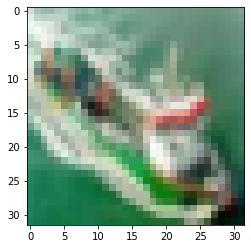

In [180]:
import matplotlib.pyplot as plt
test = x_test[15].reshape(1,3,32,32)
print(y_test[15])
test.shape
print(torch.argmax(model(test),dim=1))#.dtype)
plt.imshow(test.to(torch.uint8).numpy().reshape(32,32,3))

In [86]:
torch.argmax(model(test),dim=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1])

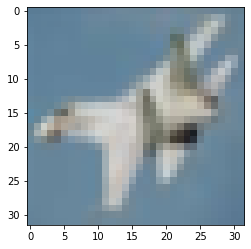

In [155]:

plt.imshow(test.to(torch.uint8).numpy().reshape(32,32,3))
